In [1]:
import IPython
print(IPython.__version__)  # Check your IPython version

%load_ext autoreload
%autoreload 2

8.23.0


In [2]:
# Add these to your notebooks to help manage memory
import gc
import torch

# Clear memory after heavy operations
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Use this periodically in your notebook
clear_memory()

In [3]:
import torch
import transformers

In [4]:


print(f"torch version: {torch.__version__}")
print(f"transformers version: {transformers.__version__}")

torch version: 2.2.2
transformers version: 4.46.3


In [5]:
import sys, os
sys.path.append('../')
sys.path.append('./')

In [ ]:
from scripts.run_benchmark import run_single_strategy_benchmark, run_benchmark

In [1]:
# from data.config import BenchmarkConfig, DatasetConfig
# from data.data import DatasetManager, ModelDataset
# from models.base_models import ModelLoader
from scripts.run_benchmark import run_single_strategy_benchmark, run_benchmark
import copy


/opt/anaconda3/envs/deep-learning-env/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/deep-learning-env/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/deep-learning-env/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


: 

In [ ]:
device = (
    "mps" if torch.backends.mps.is_available() else
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
print(f"Using device: {device}")

In [ ]:
streaming_config = BenchmarkConfig(
    model_name="TinyLlama/TinyLlama-1.1B-Chat-v0.1",  
    model_type="llama",
    device="mps",
    dtype="float16",
    strategies=["streaming"],
    max_tokens=32,
    sequence_length=512,  # Reduced
    start_size=4,
    recent_size=64,      # More reasonable size
    window_size=128,     # Reduced
    stride=64,           # Adjusted
    max_samples=10,     
    datasets=[
        DatasetConfig(
            name="super_glue",
            config="copa",
            splits=["validation"],
            input_prefix="Given the premise: ",
            output_prefix="Answer: "
        )
    ]
)

In [11]:
run_benchmark(streaming_config)

StartRecentKVCache: 4, 64


: 

In [6]:
from scripts.run_baselines import evaluate_copa
results_standard, acc_standard = evaluate_copa(
    model_name="meta-llama/Llama-3.2-1B-Instruct",
    use_streamingLLM=False,
    device="mps"
)

ModuleNotFoundError: No module named 'scripts.run_baselines'

In [26]:
base_config = BenchmarkConfig(
    model_name="TinyLlama/TinyLlama-1.1B-Chat-v0.1",
    model_type="llama",
    device="mps",
    strategies=["h2o"],
    sequence_length=256,
    max_tokens=8,
    temperature=0.1,
    start_size=4,
    cache_size=80,
    recent_size=64,
    datasets=[
        DatasetConfig(
            name="super_glue",
            config="copa",
            splits=["validation[:10]"],
            input_prefix="Given the premise: ",
            output_prefix="Answer: "
        )
    ]
)

In [27]:
run_benchmark(base_config)

2024-12-08:19:27:05,846 INFO     [run_benchmark.py:221] Running benchmark with strategies: ['h2o']
2024-12-08:19:27:05,846 INFO     [run_benchmark.py:250] 
Testing h2o strategy...
2024-12-08:19:27:05,847 INFO     [run_benchmark.py:258] Applied h2o configuration
2024-12-08:19:27:05,848 INFO     [run_benchmark.py:260] Config attention_type set to: heavy_hitter
2024-12-08:19:27:05,978 INFO     [base_models.py:34] ModelLoader: Loading model with attention type: heavy_hitter
2024-12-08:19:27:06,225 INFO     [base_models.py:56] ModelLoader: Loading with standard attention and forced caching
Evaluating h2o:   9%|▉         | 9/100 [00:04<00:42,  2.14it/s]2024-12-08:19:27:22,419 INFO     [run_benchmark.py:175] Strategy: h2o, Cache: 80%, Running accuracy: 0.6000
2024-12-08:19:27:22,419 INFO     [run_benchmark.py:180] Cache Stats: Memory=0.00MB, Avg Tokens=0.0, Layers=0
Evaluating h2o:  19%|█▉        | 19/100 [00:09<00:39,  2.06it/s]2024-12-08:19:27:27,550 INFO     [run_benchmark.py:175] Strategy

{'h2o': {'strategy': 'h2o',
  'cache_size': 80,
  'accuracy': 0.55,
  'avg_inference_time': 480.81947565078735,
  'avg_memory_usage': 5.12,
  'total_samples': 100,
  'results_file': 'copa_results_h2o_80_20241208_192805.jsonl'}}

In [ ]:
result = run_single_strategy_benchmark(
    strategy_config, 
    strategy=strategy, 
    cache_size=cache_size
)

In [ ]:
# Base configuration template
base_config = BenchmarkConfig(
    model_name="huggyllama/llama-7b",
    model_type="llama",
    device="cuda",
    sequence_length=256,
    max_tokens=32,
    temperature=0.7,
    datasets=[
        DatasetConfig(
            name="super_glue",
            config="copa",
            splits=["test"],
            input_prefix="Question: ",
            output_prefix="Answer: "
        )
    ]
)
# Full attention (baseline)
full_config = copy.deepcopy(base_config)
full_config.attention_type = "default"
run_single_strategy_benchmark(full_config, strategy="full", cache_size=100)

# H2O (Heavy-Hitter + Recent)
h2o_config = copy.deepcopy(base_config)
h2o_config.attention_type = "h2o"
h2o_config.heavy_ratio = 0.1
h2o_config.recent_ratio = 0.1
run_single_strategy_benchmark(h2o_config, strategy="h2o", cache_size=100)
run_single_strategy_benchmark(h2o_config, strategy="h2o", cache_size=80)
run_single_strategy_benchmark(h2o_config, strategy="h2o", cache_size=40)
run_single_strategy_benchmark(h2o_config, strategy="h2o", cache_size=20)
run_single_strategy_benchmark(h2o_config, strategy="h2o", cache_size=4)

# # Streaming Attention
streaming_config = copy.deepcopy(base_config)
streaming_config.attention_type = "streaming"
streaming_config.window_size = 64
streaming_config.sink_size = 4
streaming_config.sink_update_rate = 0.1
run_single_strategy_benchmark(streaming_config, strategy="streaming", cache_size=100)
run_single_strategy_benchmark(streaming_config, strategy="streaming", cache_size=80)
run_single_strategy_benchmark(streaming_config, strategy="streaming", cache_size=40)
run_single_strategy_benchmark(streaming_config, strategy="streaming", cache_size=20)
run_single_strategy_benchmark(streaming_config, strategy="streaming", cache_size=4)


# # Local/Fixed Window
local_config = copy.deepcopy(base_config)
local_config.attention_type = "local"
local_config.window_size = 64
run_single_strategy_benchmark(local_config, strategy="local", cache_size=100)
run_single_strategy_benchmark(local_config, strategy="local", cache_size=80)
run_single_strategy_benchmark(local_config, strategy="local", cache_size=40)
run_single_strategy_benchmark(local_config, strategy="local", cache_size=20)
run_single_strategy_benchmark(local_config, strategy="local", cache_size=4)

# # Liquid Fusion
liquid_config = copy.deepcopy(base_config)
liquid_config.attention_type = "liquid_fusion"
liquid_config.window_size = 64
liquid_config.sink_size = 2
liquid_config.sink_update_rate = 0.1
liquid_config.heavy_ratio = 0.1
liquid_config.recent_ratio = 0.1
run_single_strategy_benchmark(liquid_config, strategy="liquid_fusion", cache_size=100)
run_single_strategy_benchmark(liquid_config, strategy="liquid_fusion", cache_size=80)
run_single_strategy_benchmark(liquid_config, strategy="liquid_fusion", cache_size=40)
run_single_strategy_benchmark(liquid_config, strategy="liquid_fusion", cache_size=20)


In [8]:
liquid_config = copy.deepcopy(base_config)
liquid_config.attention_type = "liquid_fusion"
liquid_config.window_size = 64
liquid_config.sink_size = 2
liquid_config.sink_update_rate = 0.1
liquid_config.heavy_ratio = 0.1
liquid_config.recent_ratio = 0.1
# run_single_strategy_benchmark(liquid_config, strategy="liquid_fusion", cache_size=100)
# run_single_strategy_benchmark(liquid_config, strategy="liquid_fusion", cache_size=80)
# run_single_strategy_benchmark(liquid_config, strategy="liquid_fusion", cache_size=40)
run_single_strategy_benchmark(liquid_config, strategy="liquid_fusion", cache_size=20)


Testing liquid_fusion strategy with 20% cache
Cleaning up memory...
Converting to liquid_fusion attention...
Error: The size of tensor a (2048) must match the size of tensor b (256) at non-singleton dimension 0
Cleaning up memory...


In [76]:
import logging
import copy
from data.config import BenchmarkConfig, DatasetConfig

# Setup logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

def test_liquid_fusion():
    # Base configuration with explicit position embeddings
    base_config = BenchmarkConfig(
        model_name="TinyLlama/TinyLlama-1.1B-Chat-v0.1",
        model_type="llama",
        device="mps",
        sequence_length=256,  # Match TinyLlama's architecture
        max_tokens=32,
        temperature=0.7,
        max_position_embeddings=256,  # TinyLlama's default
        datasets=[
            DatasetConfig(
                name="super_glue",
                config="copa",
                splits=["test[:10]"],
                input_prefix="Question: ",
                output_prefix="Answer: ",
                max_samples=5
            )
        ]
    )
    # Configure Liquid Fusion with matching dimensions
    liquid_config = copy.deepcopy(base_config)
    liquid_config.attention_type = "liquid_fusion"
    liquid_config.window_size = 64
    liquid_config.sink_size = 2
    liquid_config.sink_update_rate = 0.1
    liquid_config.heavy_ratio = 0.1
    liquid_config.recent_ratio = 0.1
    liquid_config.compute_metrics = False

    logger.info("Configuration created:")
    logger.info(f"Model: {liquid_config.model_name}")
    logger.info(f"Sequence length: {liquid_config.sequence_length}")
    logger.info(f"Max position embeddings: {liquid_config.max_position_embeddings}")
    logger.info(f"Window size: {liquid_config.window_size}")
    
    try:
        from scripts.run_benchmark import run_single_strategy_benchmark
        logger.info("Starting benchmark with cache_size=20")
        result = run_single_strategy_benchmark(liquid_config, strategy="liquid_fusion", cache_size=20, num_examples=5)
        logger.info("Benchmark completed successfully")
        return result
    except Exception as e:
        logger.error(f"Error during benchmark: {str(e)}", exc_info=True)
        raise

if __name__ == "__main__":
    test_liquid_fusion()

2024-12-08:02:13:56,242 INFO     [2990294275.py:40] Configuration created:
2024-12-08:02:13:56,243 INFO     [2990294275.py:41] Model: TinyLlama/TinyLlama-1.1B-Chat-v0.1
2024-12-08:02:13:56,243 INFO     [2990294275.py:42] Sequence length: 256
2024-12-08:02:13:56,243 INFO     [2990294275.py:43] Max position embeddings: 256
2024-12-08:02:13:56,243 INFO     [2990294275.py:44] Window size: 64
2024-12-08:02:13:56,244 INFO     [2990294275.py:48] Starting benchmark with cache_size=20
2024-12-08:02:13:56,244 INFO     [run_benchmark.py:289] 
Testing liquid_fusion strategy with 20% cache
2024-12-08:02:13:56,244 INFO     [run_benchmark.py:303] Cleaning up memory...


Loading super_glue dataset (copa) (test split) with batch_size=1...
Dataset cached! Size: 500 examples


Generating outputs:   1%|          | 5/500 [00:12<21:19,  2.59s/it]
2024-12-08:02:14:18,299 INFO     [run_benchmark.py:280] 
Results saved to benchmark_results/liquid_fusion_TinyLlama-1.1B-Chat-v0.1_cache20_20241208_021418.json
2024-12-08:02:14:18,442 INFO     [2990294275.py:50] Benchmark completed successfully


2024-12-08:12:15:12,695 INFO     [rouge_scorer.py:83] Using default tokenizer.


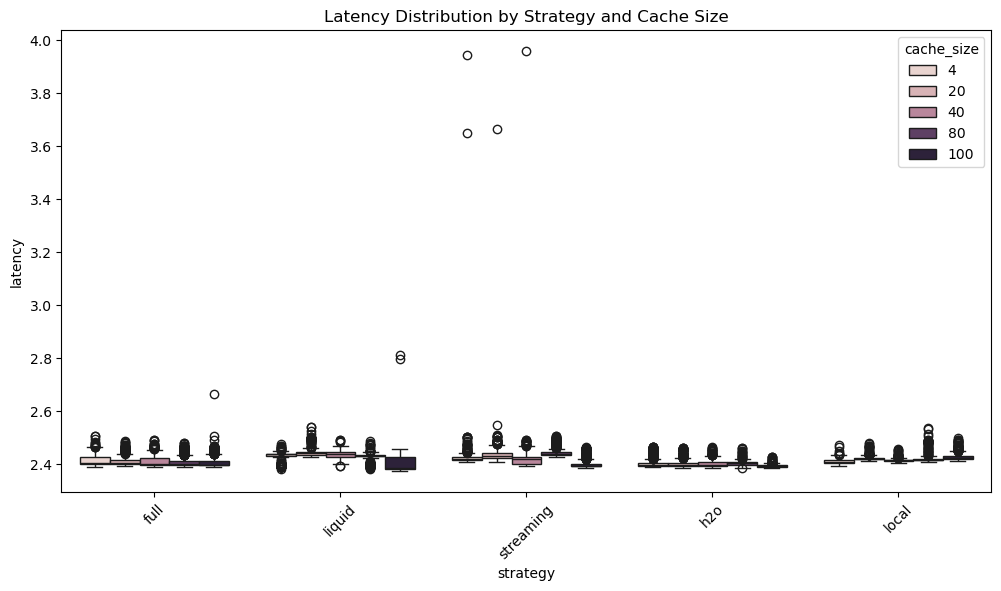


Summary Statistics:
                     latency              input_length
                        mean    std count         mean
strategy  cache_size                                  
full      4            2.413  0.021   500      128.692
          20           2.412  0.018   500      128.692
          40           2.411  0.020   500      128.692
          80           2.409  0.019   500      128.692
          100          2.408  0.022   500      128.692
h2o       4            2.404  0.018   500      128.692
          20           2.403  0.018   500      128.692
          40           2.402  0.015   500      128.692
          80           2.404  0.009   500      128.692
          100          2.394  0.005   500      128.692
liquid    4            2.429  0.019   500      128.692
          20           2.444  0.016   500      128.692
          40           2.438  0.013   500      128.692
          80           2.430  0.014   505      128.657
          100          2.401  0.034   505   

In [78]:
import json
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from rouge_score import rouge_scorer

def parse_filename(filename):
    """Extract experiment details from filename"""
    # Example: full_TinyLlama-1.1B-Chat-v0.1_cache40_20241208_181513.json
    parts = Path(filename).stem.split('_')
    
    # Find the part that starts with 'cache'
    cache_part = next(part for part in parts if part.startswith('cache'))
    cache_size = int(cache_part.replace('cache', ''))
    
    # Get timestamp (last two parts)
    timestamp = f"{parts[-2]}_{parts[-1]}"
    
    # First part is strategy
    strategy = parts[0]
    
    # Everything between strategy and cache is the model name
    model_idx_start = 1
    model_idx_end = parts.index(cache_part)
    model = '_'.join(parts[model_idx_start:model_idx_end])
    
    return {
        'strategy': strategy,
        'model': model,
        'cache_size': cache_size,
        'timestamp': timestamp
    }

def load_and_compute_rouge(results_dir='benchmark_results/'):
    """Load results and compute ROUGE scores"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    results = []
    
    for filepath in glob.glob(f"{results_dir}/*.json"):
        # Parse experiment details from filename
        exp_details = parse_filename(filepath)
        
        # Load results
        with open(filepath, 'r') as f:
            data = json.load(f)
            
        # Compute ROUGE for each generation
        for gen in data['results']['generations']:
            if isinstance(gen['input_text'], list):
                input_text = gen['input_text'][0]
            else:
                input_text = gen['input_text']
                
            result = {
                **exp_details,
                'latency': gen['latency'],
                'input_length': len(input_text),
            }
            results.append(result)
            
    return pd.DataFrame(results)

# Load data
df = load_and_compute_rouge()

# Create visualizations
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='strategy', y='latency', hue='cache_size')
plt.title('Latency Distribution by Strategy and Cache Size')
plt.xticks(rotation=45)
plt.show()

# Summary statistics
summary = df.groupby(['strategy', 'cache_size']).agg({
    'latency': ['mean', 'std', 'count'],
    'input_length': 'mean'
}).round(3)
print("\nSummary Statistics:")
print(summary)


Strategy Configuration Summary:
               window_size  sink_size  heavy_ratio
strategy                                          
full                   NaN        NaN          NaN
h2o                    NaN        NaN          0.1
liquid_fusion         64.0        4.0          0.1
local                 64.0        NaN          NaN
streaming             64.0        4.0          NaN

Latency Distribution by Strategy:
                   mean       std       min       max
strategy                                             
full           2.410685  0.020198  2.389582  2.664799
h2o            2.401423  0.014508  2.384056  2.466166
liquid_fusion  2.428592  0.025390  2.373433  2.811449
local          2.420278  0.013907  2.392591  2.537455
streaming      2.426844  0.060190  2.384177  3.959338

Output Length Distribution:
                mean  std  min  max
strategy                           
full           320.0  0.0  320  320
h2o            320.0  0.0  320  320
liquid_fusion  320.0  0.

/var/folders/qp/bmlvdp7j7qn6b6_nmx7fk8p4001p9h/T/ipykernel_89520/3487424963.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/var/folders/qp/bmlvdp7j7qn6b6_nmx7fk8p4001p9h/T/ipykernel_89520/3487424963.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


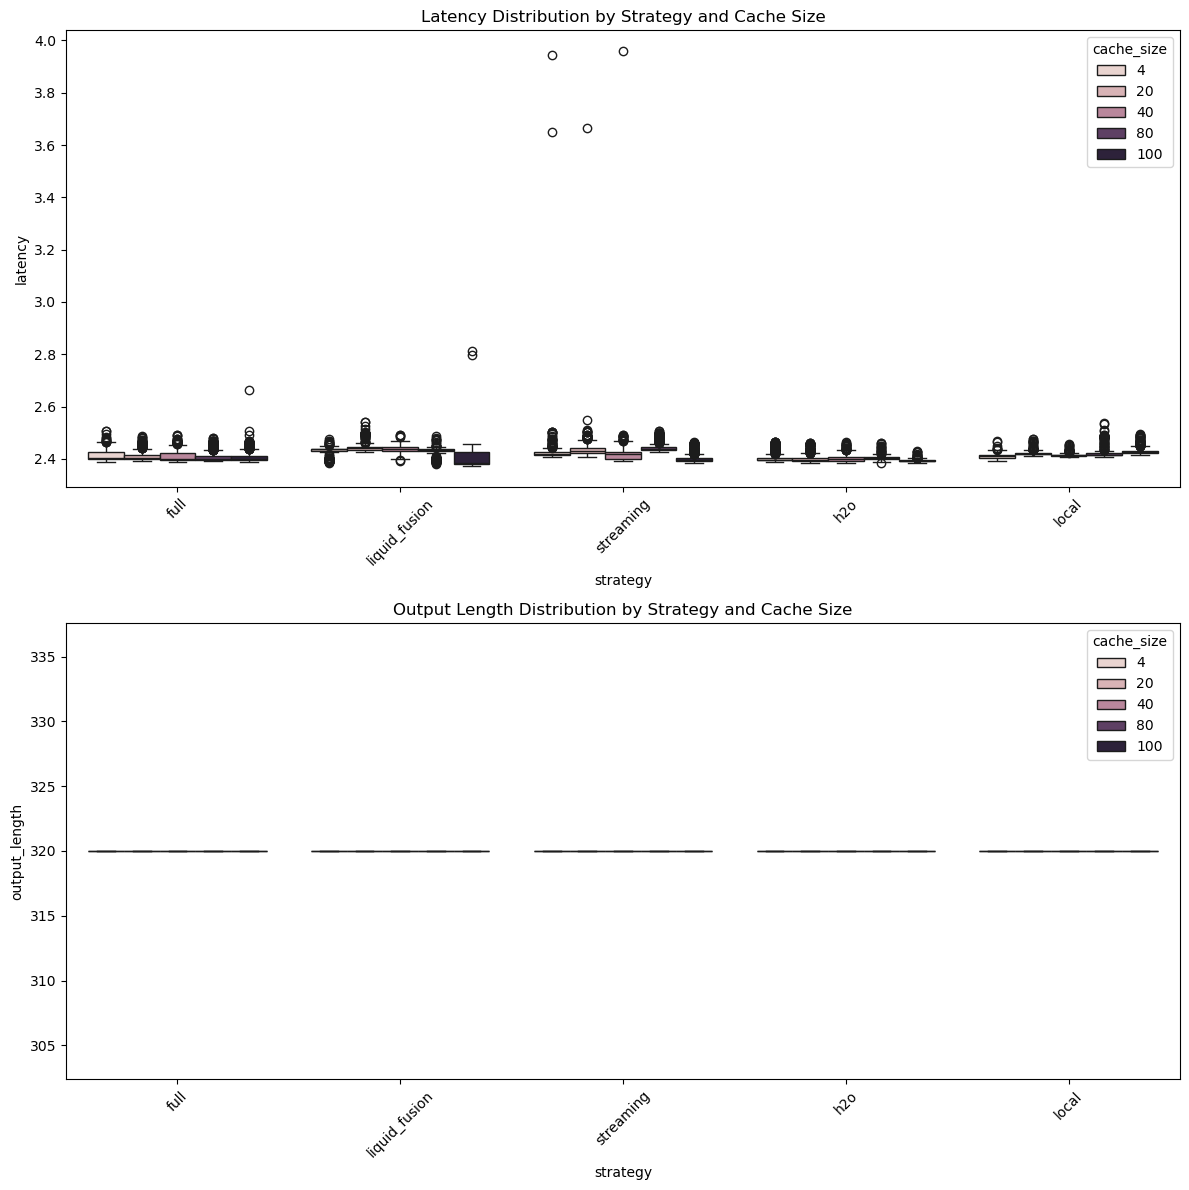

In [79]:
import json
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

def analyze_results(results_dir='benchmark_results/'):
    results = []
    
    for filepath in glob.glob(f"{results_dir}/*.json"):
        # Load full data
        with open(filepath, 'r') as f:
            data = json.load(f)
            
        # Extract metadata
        metadata = data['metadata']
        
        # Get detailed metrics for each generation
        generations = data['results']['generations']
        
        # Analyze each generation
        for idx, gen in enumerate(generations):
            results.append({
                'strategy': metadata['strategy'],
                'cache_size': metadata['cache_size'],
                'attention_type': metadata.get('attention_type'),
                'window_size': metadata.get('window_size'),
                'sink_size': metadata.get('sink_size'),
                'heavy_ratio': metadata.get('heavy_ratio'),
                'recent_ratio': metadata.get('recent_ratio'),
                'latency': gen['latency'],
                'input_length': len(gen['input_text']) if isinstance(gen['input_text'], str) 
                              else len(gen['input_text'][0]),
                'output_length': len(gen['generated_ids']),
                'example_idx': idx
            })
    
    df = pd.DataFrame(results)
    
    # Basic statistics
    print("\nStrategy Configuration Summary:")
    print(df.groupby('strategy')[['window_size', 'sink_size', 'heavy_ratio']].first())
    
    # Latency analysis
    print("\nLatency Distribution by Strategy:")
    latency_stats = df.groupby('strategy')['latency'].agg(['mean', 'std', 'min', 'max'])
    print(latency_stats)
    
    # Output length analysis
    print("\nOutput Length Distribution:")
    length_stats = df.groupby('strategy')['output_length'].agg(['mean', 'std', 'min', 'max'])
    print(length_stats)
    
    # Visualizations
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Latency distribution
    sns.boxplot(data=df, x='strategy', y='latency', hue='cache_size', ax=axes[0])
    axes[0].set_title('Latency Distribution by Strategy and Cache Size')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    
    # Output length distribution
    sns.boxplot(data=df, x='strategy', y='output_length', hue='cache_size', ax=axes[1])
    axes[1].set_title('Output Length Distribution by Strategy and Cache Size')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return df

# Run analysis
df = analyze_results()